In [1]:
import sys
sys.path.append('../../../')
import cxsystem2.neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt

#b2.codegen.target = 'numpy'

# Running network simulations

## Create neuron models

In [2]:
naud2008_json = 'naud2008_table1.json'
exc_neuron = nd.AdexNeuron()
exc_neuron.list_neurons_in_json(naud2008_json)

['cNA',
 'cAD',
 'RS',
 'Fig_4a',
 'Fig_4b',
 'Fig_4c',
 'Fig_4d',
 'Fig_4e',
 'Fig_4f',
 'Fig_4g',
 'Figs_4h']

In [3]:
exc_neuron.read_json(naud2008_json, 'RS')

In [4]:
inh_neuron = nd.AdexNeuron()
inh_neuron.read_json(naud2008_json, 'cNA')

In [5]:
exc_neuron.get_neuron_equations()

dvm/dt = (DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) - w)/C : volt (unless refractory)
dw/dt = (a*(-EL + vm) - w)/tau_w : amp


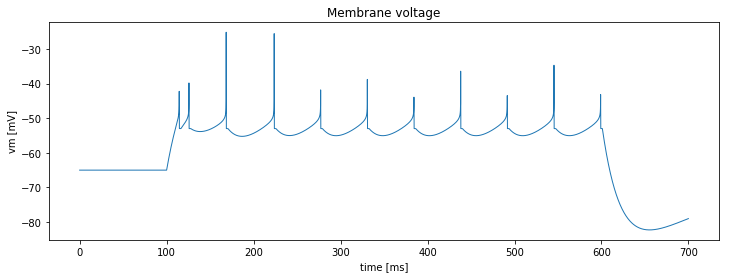

In [30]:
input = nd.input_factory.get_step_current(t_start=100, t_end=600, unit_time=ms, amplitude=150*pA)
statemon, spikemon = exc_neuron.simulate_neuron(I_stim=input, simulation_time=700*ms)
exc_neuron.plot_vm(statemon)

## Receptors

In [6]:
exc_receptor_model = 'SIMPLE_E'
inh_receptor_model = 'SIMPLE_I'

In [7]:
exc_neuron.set_excitatory_receptors(exc_receptor_model)

In [8]:
exc_neuron.get_neuron_equations()

dvm/dt = (DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) + ge*(Ee - vm) - w)/C : volt (unless refractory)
dw/dt = (a*(-EL + vm) - w)/tau_w : amp
dge/dt = -ge/tau_e : siemens


In [9]:
exc_neuron.get_neuron_parameters()  # TODO - setting receptors should set default parameters

{'C': 104. * pfarad,
 'gL': 4.3 * nsiemens,
 'EL': -65. * mvolt,
 'VT': -52. * mvolt,
 'DeltaT': 0.8 * mvolt,
 'a': -0.8 * nsiemens,
 'tau_w': 88. * msecond,
 'b': 65. * pamp,
 'V_res': -53. * mvolt,
 'refractory_period': 2. * msecond,
 'Vcut': 20. * mvolt}

In [10]:
exc_neuron.set_inhibitory_receptors(inh_receptor_model)
inh_neuron.set_excitatory_receptors(exc_receptor_model)
inh_neuron.set_inhibitory_receptors(inh_receptor_model)

In [11]:
# This shouldn't be here
exc_neuron.neuron_parameters['tau_e'] = 5.0*ms
exc_neuron.neuron_parameters['tau_i'] = 20.0*ms
exc_neuron.neuron_parameters['Ee'] = 0*mV
exc_neuron.neuron_parameters['Ei'] = -80*mV

inh_neuron.neuron_parameters['tau_e'] = 5.0*ms
inh_neuron.neuron_parameters['tau_i'] = 20.0*ms
exc_neuron.neuron_parameters['Ee'] = 0*mV
exc_neuron.neuron_parameters['Ei'] = -80*mV

## Create neuron populations

In [12]:
exc_pop = b2.NeuronGroup(3200, model=exc_neuron.get_neuron_equations(),
                             namespace=exc_neuron.get_neuron_parameters(),
                             reset=exc_neuron.get_reset_statements(),
                             threshold=exc_neuron.get_threshold_condition(), 
                             refractory=exc_neuron.get_refractory_period())

In [13]:
inh_pop = b2.NeuronGroup(800, model=inh_neuron.get_neuron_equations(), 
                             namespace=exc_neuron.get_neuron_parameters(),
                             reset=inh_neuron.get_reset_statements(),
                             threshold=inh_neuron.get_threshold_condition(), 
                             refractory=inh_neuron.get_refractory_period())

In [14]:
exc_pop

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

## Connecting the groups

In [15]:
exc_weight = 3*nS
inh_weight = 6*nS
Syn_EE = b2.Synapses(exc_pop, exc_pop, on_pre='ge_post += exc_weight')
Syn_EI = b2.Synapses(exc_pop, inh_pop, on_pre='ge_post += exc_weight')
Syn_IE = b2.Synapses(inh_pop, exc_pop, on_pre='gi_post += inh_weight')
Syn_II = b2.Synapses(inh_pop, inh_pop, on_pre='gi_post += inh_weight')

In [16]:
Syn_EE.connect(p=0.02)
Syn_EI.connect(p=0.02)
Syn_IE.connect(p=0.02)
Syn_II.connect(p=0.02)

## Creating monitors and setting the initial values

In [17]:
exc_spikes = b2.SpikeMonitor(exc_pop)
inh_spikes = b2.SpikeMonitor(inh_pop)
exc_vm = b2.StateMonitor(exc_pop, ['vm'], record=True)
inh_vm = b2.StateMonitor(inh_pop, ['vm'], record=True)

In [18]:
exc_pop.vm = 'VT - randn()*5*mV'
inh_pop.vm = 'VT - randn()*5*mV'

## Running the simulation

In [19]:
b2.run(1000*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


## Visualize results

In [20]:
from brian2tools import brian_plot

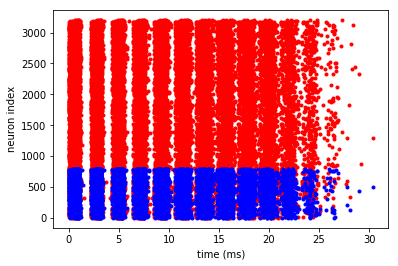

In [21]:
plt.Figure()
ax = plt.gca()
brian_plot(exc_spikes, axes=ax, c='red')
brian_plot(inh_spikes, axes=ax, c='blue')

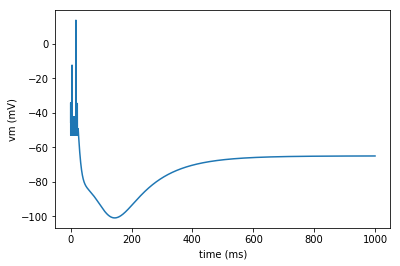

In [29]:
brian_plot(inh_vm[100])